# Clasificación de imágenes

Basado en [TUTORIAL TENSORFLOW](https://www.tensorflow.org/tutorials/images/classification?hl=es-419#download_and_explore_the_dataset)

Este tutorial muestra cómo clasificar imágenes de flores. Crea un clasificador de imágenes usando un modelo tf.keras.Sequential y carga datos usando tf.keras.utils.image_dataset_from_directory . Adquirirás experiencia práctica con los siguientes conceptos:

* Carga eficiente de un conjunto de datos fuera del disco.
* Identificar el sobreajuste y aplicar técnicas para mitigarlo, incluido el aumento y la eliminación de datos.

Este tutorial sigue un flujo de trabajo básico de aprendizaje automático:

1. Examinar y comprender los datos.
1. Crear una canalización de entrada
1. Construye el modelo
1. entrenar al modelo
1. Probar el modelo
1. Mejorar el modelo y repetir el proceso

# Descargar el conjunto de datos de Café

## Cargar variables para la API de Kaggle

Descargar el .json y moverlo a la ruta /root/.kaggle

In [9]:
!kaggle datasets download -d gpiosenka/coffee-bean-dataset-resized-224-x-224 -p /keras_portfolio/data/

100%|███████████████████████████████████████▉| 144M/144M [00:07<00:00, 20.1MB/s]
100%|████████████████████████████████████████| 144M/144M [00:07<00:00, 19.0MB/s]


In [ ]:
!unzip -q /keras_portfolio/data/coffee-bean-dataset-resized-224-x-224.zip -d /keras_portfolio/data/

In [1]:
%cd /keras_portfolio/Coffee\ Classification

/keras_portfolio/Coffee Classification


/usr/local/lib/python3.11/dist-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
!pwd

/keras_portfolio/Coffee Classification


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

2024-04-09 05:55:34.495874: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-09 05:55:35.135949: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-09 05:55:35.136579: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-09 05:55:35.226667: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-09 05:55:35.489228: I tensorflow/core/platform/cpu_feature_guar

In [4]:
images = pd.read_csv("data/Coffee Bean.csv")

In [5]:
images.shape

(1600, 4)

In [6]:
images.head()

,class index,filepaths,labels,data set
0,0,train/Dark/dark (1).png,Dark,train
1,0,train/Dark/dark (10).png,Dark,train
2,0,train/Dark/dark (100).png,Dark,train
3,0,train/Dark/dark (101).png,Dark,train
4,0,train/Dark/dark (102).png,Dark,train


In [7]:
images["data set"].value_counts(normalize=False)

data set
train    1200
test      400
Name: count, dtype: int64

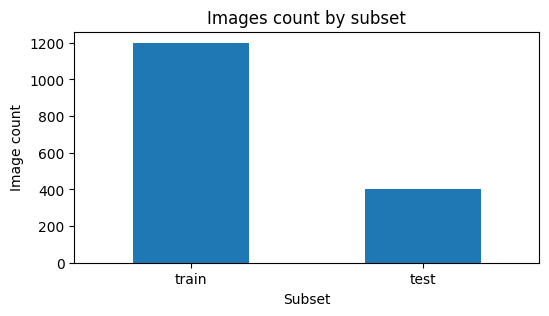

In [8]:
plt.figure(figsize=(6,3))
images["data set"].value_counts(normalize=False).plot(kind="bar")
plt.xticks(rotation=0)
plt.title("Images count by subset")
plt.xlabel("Subset")
plt.ylabel("Image count")
plt.show()

In [9]:
images["class index"].value_counts(normalize=False)

class index
0    400
1    400
2    400
3    400
Name: count, dtype: int64

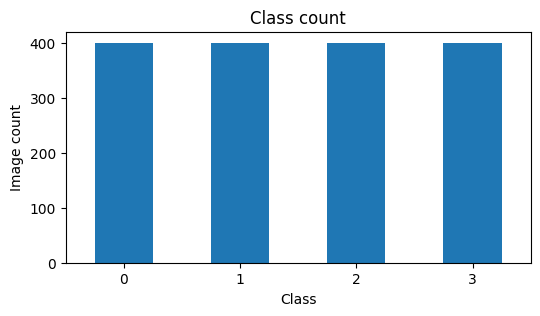

In [10]:
plt.figure(figsize=(6,3))
images["class index"].value_counts(normalize=False).plot(kind="bar")
plt.xticks(rotation=0)
plt.title("Class count")
plt.xlabel("Class")
plt.ylabel("Image count")
plt.show()

All classes have 400 instances

In [11]:
images.sample(9)

,class index,filepaths,labels,data set
431,1,train/Green/green (217).png,Green,train
236,0,train/Dark/dark (41).png,Dark,train
99,0,train/Dark/dark (189).png,Dark,train
114,0,train/Dark/dark (201).png,Dark,train
704,2,train/Light/light (193).png,Light,train
545,1,train/Green/green (5).png,Green,train
465,1,train/Green/green (248).png,Green,train
1237,0,test/Dark/dark (42).png,Dark,test
1255,0,test/Dark/dark (59).png,Dark,test


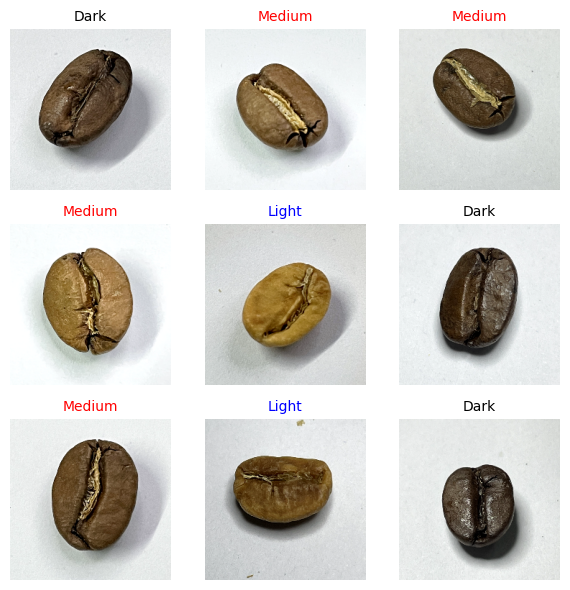

In [12]:
from pathlib import Path

dataset = Path("data")
colors = ['black', 'green', 'blue', 'red']

plt.figure(figsize=(6,6))
for i, row in enumerate(images.sample(9).iterrows()):
    class_id, filepath, label = row[1]["class index"], row[1]["filepaths"], row[1]["labels"]
    img = plt.imread(dataset / filepath)
    color = colors[class_id]

    plt.subplot(3,3,i+1)
    plt.imshow(img)
    plt.title(f"{label}", fontsize=10, color=color)
    plt.axis("off")

plt.tight_layout()
plt.show()

## Crear un conjunto de datos
Defina algunos parámetros para el cargador:

In [13]:
batch_size = 32
img_height = 128
img_width = 128

In [14]:
from sklearn.model_selection import train_test_split

images = pd.read_csv("data/Coffee Bean.csv")
images["filepaths"] = images["filepaths"].apply(lambda x: str(dataset / x))
df_train = images[images['data set'] == 'train']
df_test = images[images['data set'] == 'test']

df_val, df_test, y_val, y_test = train_test_split(
    df_test[["filepaths"]], df_test["labels"], test_size=0.2,
    stratify=df_test["labels"],
)

df_val["labels"] = y_val
df_test["labels"] = y_test

print(f"{df_train.shape = }")
print(f"{df_val.shape = }")
print(f"{df_test.shape = }")

df_train.shape = (1200, 4)
df_val.shape = (320, 2)
df_test.shape = (80, 2)


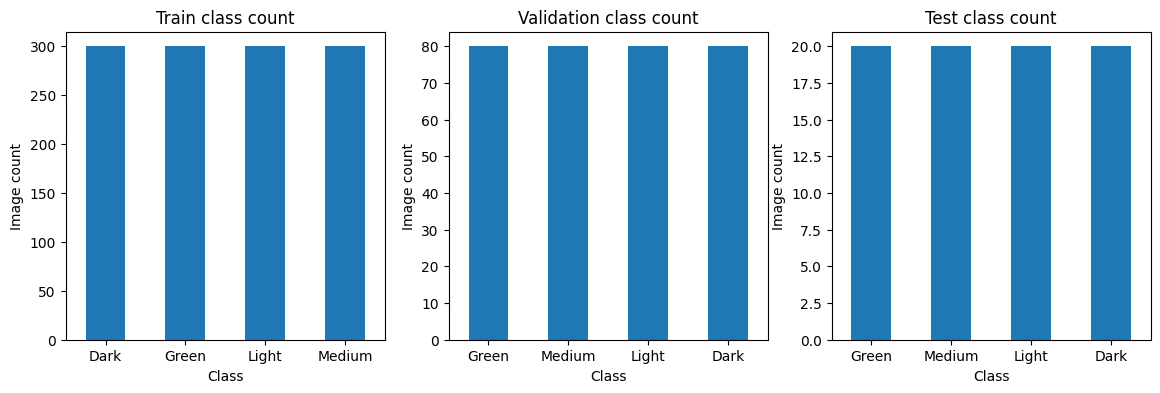

In [15]:
plt.figure(figsize=(14, 4))

plt.subplot(1, 3, 1)
df_train["labels"].value_counts(normalize=False).plot(kind="bar")
plt.xticks(rotation=0)
plt.title("Train class count")
plt.xlabel("Class")
plt.ylabel("Image count")

plt.subplot(1, 3, 2)
df_val["labels"].value_counts(normalize=False).plot(kind="bar")
plt.xticks(rotation=0)
plt.title("Validation class count")
plt.xlabel("Class")
plt.ylabel("Image count")

plt.subplot(1, 3, 3)
df_test["labels"].value_counts(normalize=False).plot(kind="bar")
plt.xticks(rotation=0)
plt.title("Test class count")
plt.xlabel("Class")
plt.ylabel("Image count")

plt.show()

In [16]:
from keras.preprocessing.image import ImageDataGenerator

# Crea generadores de datos utilizando ImageDataGenerator para aumento de datos (data augmentation) si es necesario
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normaliza los valores de píxeles al rango [0, 1]
    # rotation_range=20,  # Rango de rotación aleatoria
    # width_shift_range=0.2,  # Rango de desplazamiento horizontal aleatorio
    # height_shift_range=0.2,  # Rango de desplazamiento vertical aleatorio
    # shear_range=0.2,  # Rango de deformación de corte
    # zoom_range=0.2,  # Rango de zoom aleatorio
    horizontal_flip=True,  # Volteo horizontal aleatorio
    vertical_flip=True,
    # brightness_range=(0.95, 1.05),
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
)

# Crea generadores de datos utilizando flow_from_dataframe para cargar imágenes desde las carpetas 'train' y 'test'
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    x_col='filepaths',  # Columna que contiene las rutas de las imágenes
    y_col='labels',  # Columna que contiene las etiquetas de las imágenes
    target_size=(img_height, img_width),  # Tamaño de las imágenes (ajustar según sea necesario)
    batch_size=32,  # Tamaño del lote
    class_mode='categorical'  # Modo de clase (categórico para etiquetas codificadas one-hot)
)

val_generator = test_datagen.flow_from_dataframe(
    dataframe=df_val,
    x_col='filepaths',
    y_col='labels',
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    x_col='filepaths',
    y_col='labels',
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
)

Found 1200 validated image filenames belonging to 4 classes.
Found 320 validated image filenames belonging to 4 classes.
Found 80 validated image filenames belonging to 4 classes.


Puede encontrar los nombres de clase en el atributo **class_names** en estos conjuntos de datos. Estos corresponden a los nombres de los directorios en orden alfabético.

In [17]:
class_names = list(train_generator.class_indices.keys())
print(class_names)

['Dark', 'Green', 'Light', 'Medium']


## Visualiza los datos con data augmentation

Aquí están las primeras nueve imágenes del conjunto de datos de entrenamiento:

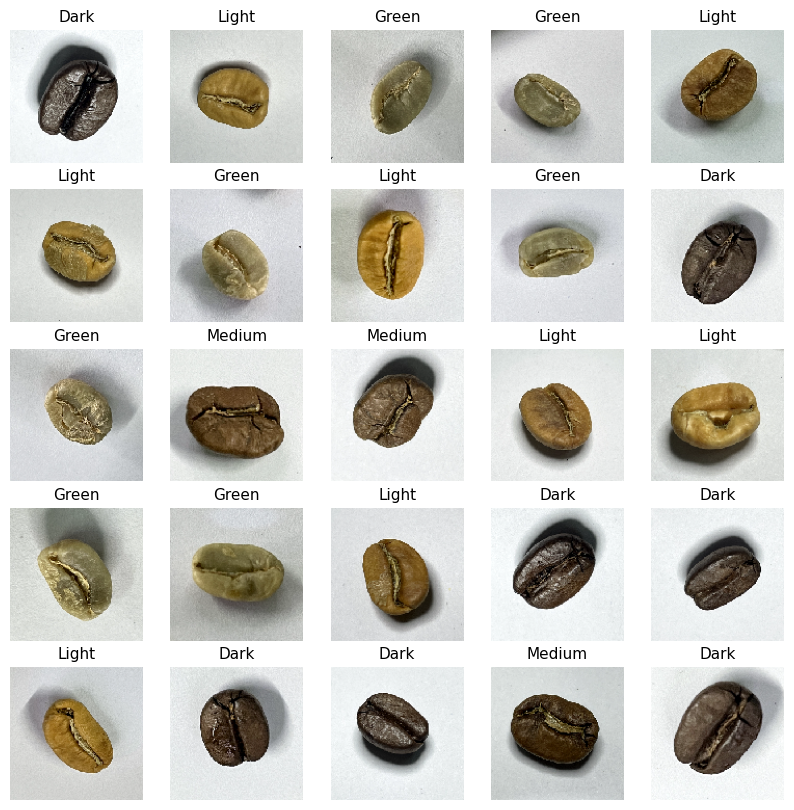

In [18]:
nrows, ncols = 5, 5
plt.figure(figsize=(10, 10))
images, labels = next(train_generator)  # Obtiene un lote de imágenes y etiquetas del generador
for i in range(nrows*ncols):
    ax = plt.subplot(nrows, ncols, i + 1)
    plt.imshow(images[i])  # No es necesario llamar a .numpy() aquí
    plt.title(class_names[labels[i].argmax()], fontsize=11)  # Convierte etiquetas one-hot en el índice de la clase
    plt.axis("off")

plt.show()

In [19]:
for image_batch, labels_batch in train_generator:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 128, 128, 3)
(32, 4)


# Crear el modelo

In [21]:
#pruebas
num_classes = len(class_names)

model = Sequential([
  layers.InputLayer ( input_shape=(img_height, img_width, 3) ),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),

  # layers.Flatten(),
  layers.GlobalAveragePooling2D(),
  layers.Dense(32, activation='relu'),
  layers.Dense(16, activation='relu'),
  layers.Dense(num_classes, activation="softmax"),
])

In [22]:
model.compile(optimizer = 'adam',
              loss      = tf.keras.losses.CategoricalCrossentropy(),
              metrics   = ['accuracy']
              )

In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 64, 64, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 32, 32, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 16, 16, 64)       

In [25]:
epochs = 25
%time history1 = model.fit(train_generator, validation_data=val_generator, epochs=epochs, verbose=1)

Epoch 1/25


2024-04-09 05:57:21.261365: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-04-09 05:57:22.002991: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
2024-04-09 05:57:25.081588: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f2156c2d030 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-09 05:57:25.081698: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-04-09 05:57:25.150016: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1712642245.417432   50435 device_compiler.h:186] Compiled c

38/38 [==============================] - 30s 575ms/step - loss: 1.3814 - accuracy: 0.2558 - val_loss: 1.3634 - val_accuracy: 0.2500
Epoch 2/25
38/38 [==============================] - 21s 550ms/step - loss: 1.2636 - accuracy: 0.3483 - val_loss: 1.0627 - val_accuracy: 0.4875
Epoch 3/25
38/38 [==============================] - 22s 585ms/step - loss: 0.9309 - accuracy: 0.5375 - val_loss: 0.8033 - val_accuracy: 0.7188
Epoch 4/25
38/38 [==============================] - 22s 586ms/step - loss: 0.6855 - accuracy: 0.7458 - val_loss: 0.5305 - val_accuracy: 0.9187
Epoch 5/25
38/38 [==============================] - 22s 578ms/step - loss: 0.4322 - accuracy: 0.8700 - val_loss: 0.2476 - val_accuracy: 0.9531
Epoch 6/25
38/38 [==============================] - 21s 559ms/step - loss: 0.2428 - accuracy: 0.9358 - val_loss: 0.1547 - val_accuracy: 0.9656
Epoch 7/25
38/38 [==============================] - 21s 560ms/step - loss: 0.1684 - accuracy: 0.9533 - val_loss: 0.1140 - val_accuracy: 0.9625
Epoch 8/25

# Visualiza los resultados del entrenamiento

Cree gráficos de pérdida y precisión en los conjuntos de entrenamiento y validación:

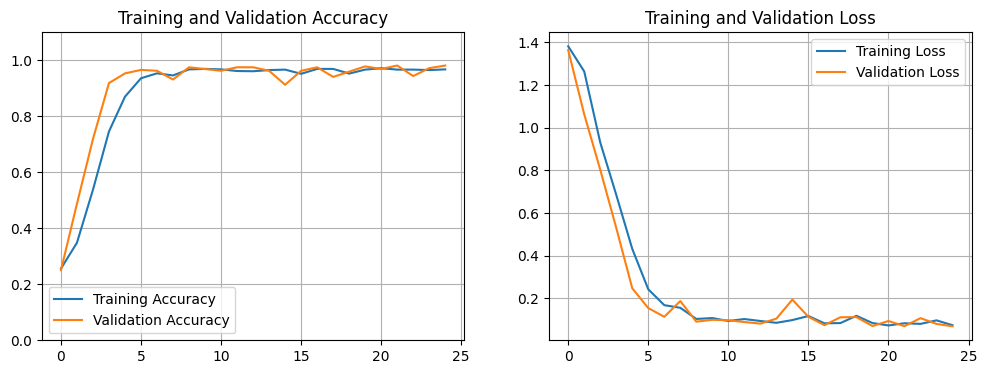

In [26]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='best')
plt.ylim([0,1.1])
plt.grid(True)
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='best')
plt.grid(True)
plt.title('Training and Validation Loss')
plt.show()

In [27]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Hacer predicciones en los datos de prueba
predictions = model.predict(test_generator)

# Convertir las predicciones de las etiquetas codificadas one-hot a etiquetas numéricas
predicted_labels = np.argmax(predictions, axis=1)

# Obtener las etiquetas reales de los datos de prueba
true_labels = test_generator.classes

# Calcular la matriz de confusión
confusion_mtx = confusion_matrix(true_labels, predicted_labels)

print(confusion_mtx)

3/3 [==============================] - 1s 377ms/step
[[20  0  0  0]
 [ 0 20  0  0]
 [ 0  0 20  0]
 [ 3  0  1 16]]


In [28]:
class_names

['Dark', 'Green', 'Light', 'Medium']

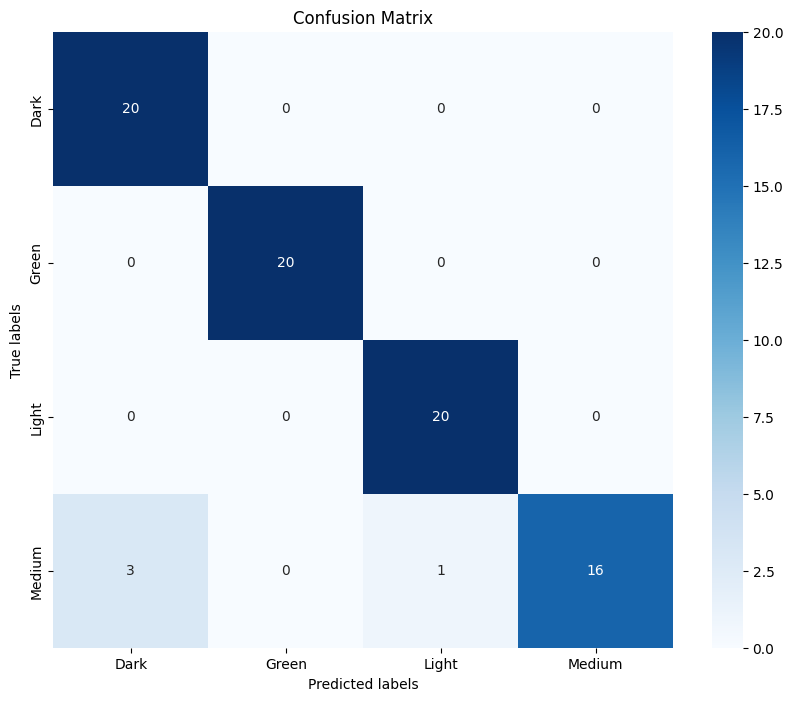

In [29]:
import seaborn as sns

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', 
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [31]:
from sklearn.metrics import classification_report
print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93        20
           1       1.00      1.00      1.00        20
           2       0.95      1.00      0.98        20
           3       1.00      0.80      0.89        20

    accuracy                           0.95        80
   macro avg       0.96      0.95      0.95        80
weighted avg       0.96      0.95      0.95        80

